导入库

In [1]:
import os
import imp
import numpy as np

import utils
imp.reload(utils)

/tmp/ipykernel_3702674/1016847511.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'utils' from '/data1/byzhao/EEG-AudioTransformer/utils.py'>

公共变量

In [2]:
words_path = r'./feat/words'
pts = ['sub-%02d'%i for i in range(1,11)]

读取数据

In [3]:
eeg = dict()
audio = dict()
word = dict()
for pt in pts:
    folder_path = os.path.join(words_path,f'{pt}')
    word[pt] = []
    eeg[pt] = []
    audio[pt] = []
    for filename in os.listdir(folder_path):
        word_info = np.load(os.path.join(folder_path,filename),allow_pickle=True)
        word[pt].append(word_info.item()['label'])
        eeg[pt].append(word_info.item()['eeg'])
        audio[pt].append(word_info.item()['audio'])


In [4]:
for pt in pts:
    print(f'{pt}:',word[pt][0],len(eeg[pt]),eeg[pt][0].shape,audio[pt][0].shape)

sub-01: hij 100 (594, 127) (9280,)
sub-02: door 100 (829, 127) (12960,)
sub-03: te 100 (492, 127) (7680,)
sub-04: al 100 (727, 115) (11360,)
sub-05: nog 100 (727, 60) (11360,)
sub-06: om 100 (809, 127) (12640,)
sub-07: de 100 (491, 127) (7680,)
sub-08: maantje 100 (901, 54) (14080,)
sub-09: vier 100 (717, 117) (11200,)
sub-10: veel 95 (532, 122) (8320,)


数据预处理

In [5]:
window_length = 0.025
frameshift = 0.005
eeg_sample_rate = 1024
audio_sameple_rate = 16000

提取高频eeg信号和音频信号的梅尔频谱

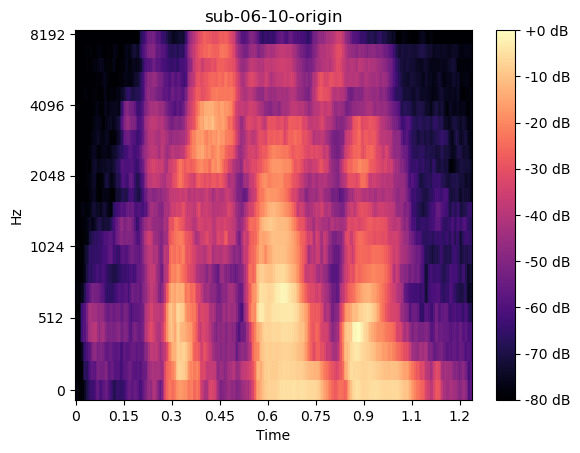

(248, 23)


In [6]:
import librosa
import matplotlib.pyplot as plt

plt.figure()
test = utils.extractMelSpecs(audio['sub-06'][10],audio_sameple_rate,windowLength=window_length,frameshift=frameshift)
librosa.display.specshow(test.T,sr=16000,hop_length=80,win_length=400,x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')        
plt.title(f'sub-06-10-origin')
plt.show()
print(test.shape)

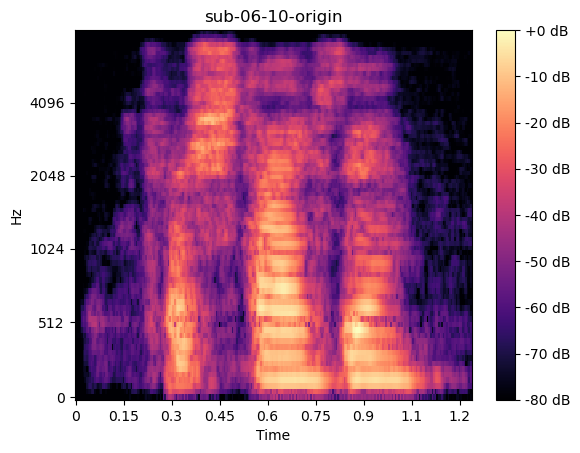

In [15]:
spectrogram = librosa.feature.melspectrogram(y=audio['sub-06'][10].astype('float'),sr=16000,n_fft=400,hop_length=80,center=False,n_mels=80)
spectrogram = librosa.power_to_db(spectrogram,ref=np.max).T
plt.figure()
# test = utils.extractMelSpecs(audio['sub-06'][10],audio_sameple_rate,windowLength=window_length,frameshift=frameshift)
librosa.display.specshow(spectrogram.T,sr=16000,hop_length=80,win_length=400,x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')        
plt.title(f'sub-06-10-origin')
plt.show()

In [83]:
for pt in pts:
    for i in range(len(eeg[pt])):
        eeg[pt][i] = utils.extractHG(eeg[pt][i],eeg_sample_rate,windowLength=window_length,frameshift=frameshift)
        audio[pt][i] = utils.extractMelSpecs(audio[pt][i],audio_sameple_rate,windowLength=window_length,frameshift=frameshift)
        if audio[pt][i].shape[0]!=eeg[pt][i].shape[0]:
            minlen = min(audio[pt][i].shape[0],eeg[pt][i].shape[0])
            audio[pt][i] = audio[pt][i][:minlen,:]
            eeg[pt][i] = eeg[pt][i][:minlen,:]

In [84]:
for pt in pts:
    print(f'{pt}:',word[pt][0],len(eeg[pt]),eeg[pt][0].shape,audio[pt][0].shape)

sub-01: hij 100 (111, 127) (111, 40)
sub-02: door 100 (156, 127) (156, 40)
sub-03: te 100 (91, 127) (91, 40)
sub-04: al 100 (136, 115) (136, 40)
sub-05: nog 100 (136, 60) (136, 40)
sub-06: om 100 (153, 127) (153, 40)
sub-07: de 100 (90, 127) (90, 40)
sub-08: maantje 100 (170, 54) (170, 40)
sub-09: vier 100 (135, 117) (135, 40)
sub-10: veel 95 (98, 122) (98, 40)


拼接方便后续处理

In [85]:
# def concateData(pt):
total_data = dict()
total_label = dict()
for pt in pts:
    total_data[pt] = np.array(eeg[pt][0])
    total_label[pt] = np.array(audio[pt][0])
    for i in range(len(eeg[pt])):
        if i == 0:
            continue
        total_data[pt] = np.concatenate((total_data[pt],eeg[pt][i]),axis=0)
        total_label[pt] = np.concatenate((total_label[pt],audio[pt][i]),axis=0)
        # np.save(os.path.join('feat',f'{pt}_data.npy'),total_data)
    np.save(os.path.join('feat',f'{pt}_label_40.npy'),total_label[pt])
        # print(total_data.shape)

In [ ]:
pt = pts[5]
total_data = total_data[pt]
total_label = total_label[pt]

z均值处理

In [36]:
# 随机打乱数据索引
indices = np.random.permutation(total_data.shape[0])

# 计算划分索引
split_index = int(total_data.shape[0] * 0.9)

# 划分数据集
train_indices = indices[:split_index]
test_indices = indices[split_index:]

# 获取训练集和测试集数据
train_data = total_data[train_indices]
train_label = total_label[train_indices]
test_data = total_data[test_indices]
test_label = total_label[test_indices]

train_data_mean = np.mean(train_data)
train_data_std = np.std(train_data)

train_label_mean = np.mean(train_label)
train_label_std = np.std(train_label)


train_data = (train_data-train_data_mean)/train_data_std
test_data = (test_data-train_data_mean)/train_data_std

# train_label = (train_label-train_label_mean)/train_label_std
# test_label = (test_label- train_label_std)/train_label_std

print(train_data.shape)
# print(train_data[0])
# print(train_data[1])
print(train_label[0])
print(train_label[1])

(14605, 127)
[ 9.66860329 10.39320445  9.23300435  8.3650588   9.15385251  9.23856046
  8.97066423  9.34830402  8.49646346  8.32958059  8.57679341  8.29289333
  8.36476925  8.84106281  8.95595069  8.68060027  7.88845709  6.86665788
  6.51924201  6.19771169  6.45267324  5.87137127  3.54546015]
[6.1012631  6.98797618 6.48217311 6.53079611 6.80194787 6.55231325
 6.47250046 5.85198999 5.49127502 5.18706556 5.62838955 5.5433698
 5.61552868 5.80438955 5.72948746 6.01277679 7.09042082 7.02468877
 7.32906112 7.88003409 8.02584928 6.58314508 3.84818796]


创建dataloader

In [37]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from torch.utils.data import TensorDataset, DataLoader

import transformer
imp.reload(transformer)

<module 'transformer' from '/data1/byzhao/EEG-AudioTransformer/transformer.py'>

In [38]:
batch_size = 512
epochs = 1000
print_interval = 5
lr = 0.00002
b1 = 0.5
b2 = 0.999
input_dim = total_data.shape[1]
output_dim = total_label.shape[1]
d_model = 256
nhead = 4
n_layer =6
tensor_type = torch.cuda.FloatTensor

# log_write = open(f"./log/log_{pt}.txt", "w") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = transformer.Model(
    input_dim=input_dim,
    output_dim=output_dim,
    d_model=d_model,
    nhead=nhead,
    n_layer=n_layer
).to(device)

# criterion = nn.MSELoss(reduction='mean').to(device)
criterion = nn.L1Loss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(b1,b2))

print(input_dim,output_dim)

127 23


In [39]:
train_data = torch.from_numpy(train_data)
train_label = torch.from_numpy(train_label)
test_data = torch.from_numpy(test_data).to(device).type(tensor_type)
test_label = torch.from_numpy(test_label).to(device).type(tensor_type)

train_dataset = TensorDataset(train_data,train_label)
# test_dataset = TensorDataset(test_data,test_label)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)


In [40]:
import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'./logs/{pt}')

writer.add_graph(model,test_data)

In [41]:
pbar = tqdm.trange(epochs, desc=f"Epochs")

for e in pbar:
    model.train()
    aver_loss= 0
    for _, (data, label) in enumerate(train_dataloader):
        data = data.to(device)
        data = data.type(tensor_type)
        label = label.to(device)
        label = label.type(tensor_type)
        outputs = model(data)
        loss = criterion(outputs, label)
        aver_loss+=loss.detach().cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # if (e + 1) % print_interval == 0:
    model.eval()
    test_outputs = model(test_data)
    test_loss = criterion(test_outputs, test_label).detach().cpu().numpy()
    aver_loss = aver_loss/len(train_dataloader)
    pbar.set_postfix({'average loss':aver_loss,'test loss':test_loss})
    writer.add_scalar('average loss',aver_loss,e)
    writer.add_scalar('test loss',test_loss,e)
    # log_write.write(f'{e}\t\t{aver_loss}\t\t{test_loss}\n')
    # log_write.flush()

torch.save(model.state_dict(), f'./res/{pt}_model.pth')
writer.close()

Epochs: 100%|██████████| 1000/1000 [20:09<00:00,  1.21s/it, average loss=0.374, test loss=0.3993194]


In [42]:
test_outputs = model(test_data)
print(test_outputs.detach().cpu().numpy())
print(test_label.detach().cpu().numpy())

[[ 6.8912926  7.8354187  7.1075716 ...  9.470028   8.355508   5.39604  ]
 [ 9.175585  10.351564  10.124961  ...  3.817961   3.1157362  1.6826704]
 [11.175567  12.045138  12.403337  ...  6.6445494  5.9737263  3.0142045]
 ...
 [ 4.6593966  5.338602   4.806968  ...  5.707938   5.2142453  3.0851104]
 [ 8.389989   9.372262   8.715365  ...  7.4262714  6.9215603  4.4180436]
 [ 9.569234  10.742181   9.771005  ...  4.087042   3.5551336  1.9723558]]
[[ 6.239411   7.645665   7.3586335 ... 10.303515   8.433252   5.2470865]
 [ 8.861689  10.334457  10.338662  ...  3.8817415  3.092787   1.7568482]
 [11.29953   12.10925   12.6056185 ...  6.7364388  6.302524   2.7365558]
 ...
 [ 4.8163075  5.3071556  5.580255  ...  6.352319   5.737907   3.558425 ]
 [ 8.618947   9.813481   9.242043  ...  6.9368     6.650194   4.489153 ]
 [10.447141  11.541962   9.942531  ...  3.8754747  3.4008098  1.8305255]]
